In [1]:
import re, sys
import pandas as pd
import matplotlib.pyplot as plt

from dGbyG.api import Compound, Reaction
from dGbyG.utils.ChemFunc import *
from dGbyG.utils.constants import *

Preparation of raw data

In [2]:
tecrdb = pd.read_csv('../data/experimental_dG_from_eQ/TECRDB.csv')

data={'COCOM00001': '[O-]C(=O)C1=C(Cl)C(Cl)=CC=C1',
      'COCOM00002': '[O-]C(=O)C1=CC(Cl)=CC(Cl)=C1',
      'COCOM00003': '[O-]C(=O)C1=C(Cl)C(Cl)=CC(Cl)=C1',
      'COCOM00004': '[O-]C(=O)C1=CC(Cl)=C(Cl)C(Cl)=C1',
      'COCOM00005': '[O-]C(=O)C1=CC(Br)=CC=C1',
      'COCOM00006': '[O-]C(=O)C1=CC(I)=CC=C1',
      'COCOM00007': 'NC1=C(C=C(Cl)C=C1)C([O-])=O',
      'COCOM00008': 'OC1=C(C=C(Cl)C=C1)C([O-])=O',
      'COCOM00009': 'CC1=C(C=C(Cl)C=C1)C([O-])=O',
      'COCOM00010': 'CCC(C)Cl',
      'COCOM00011': 'C[N+](C)(C)[O-]',
      'COCOM00012': 'CC(=O)C1=C[N+](=CC=C1)C1OC(COP([O-])(=O)OP([O-])(=O)OCC2OC(C(O)C2O)N2C=NC3=C(N)N=CN=C23)C(O)C1O',
      'COCOM00013': 'CC(=O)C1=CN(C=CC1)C1OC(COP([O-])(=O)OP([O-])(=O)OCC2OC(C(O)C2O)N2C=NC3=C(N)N=CN=C23)C(O)C1O'}
equilibrator_df = pd.DataFrame(data=data.items(), columns=['id', 'Smiles'], ).set_index(keys='id')

Translation of various compound ids to Smiles format

In [3]:
tecrdb_copy = tecrdb.loc[:,['description', 'reaction', 'K_prime', 'temperature', 'ionic_strength', 'p_h', 'p_mg', 'EC']].copy()

for i in tecrdb_copy.index:
    r = tecrdb_copy.loc[i,'reaction']
    reaction = parse_equation(r)
    rxn = {}
    for name, coeff in reaction.items():
        name = name.strip()
        if c := re.match(r'^kegg:(C\d{5})$', name):
            kegg_entry = c.group(1)
            mol = to_mol(kegg_entry, 'kegg')
        elif c := re.match(r'^metanetx.chemical:(.+)$', name):
            metanetx_id = c.group(1)
            mol = to_mol(metanetx_id, 'metanetx')
        elif c := re.match(r'COCO:(.+)$', name):
            equilibrator_id = c.group(1)
            smiles = equilibrator_df.loc[equilibrator_id, 'Smiles']
            mol = to_mol(smiles, 'Smiles')
        else:
            print(i)

        if not mol:
            rxn = pd.NA
            break
        
        compound = Compound(mol)
        smiles = compound.Smiles # record smiles of the compound
        rxn[smiles] = coeff
    
    rxn = build_equation(rxn) if pd.notna(rxn) else pd.NA
    tecrdb_copy.loc[i,'reaction'] = rxn

Removing incomplete data, renaming columns, and computing non-transformed standard dg primes

In [4]:
tecrdb_copy = tecrdb_copy.loc[pd.notna(tecrdb_copy.loc[:,['reaction', 'K_prime']]).all(axis=1),:]
tecrdb_copy = tecrdb_copy.rename(columns={'temperature':'T', 'ionic_strength':'I', 'p_h':'pH', 'p_mg':'pMg'})
nontrans_standard_dg_primes = [(-R * row.T * np.log(row.K_prime)) for row in tecrdb_copy.itertuples()]
tecrdb_copy = tecrdb_copy.assign(**{"nontrans_standard_dg_primes": nontrans_standard_dg_primes})

Balancing the reactions with H2O and H+ if possible, else remove them.

In [5]:
balanced = []
for i in tecrdb_copy.index:
    r = tecrdb_copy.loc[i, 'reaction']
    r = Reaction(r, cid_type='smiles')
    if not r.is_balanced():
        balanced.append(False)
    else:
        tecrdb_copy.loc[i, 'reaction'] = r.equationSmiles
        balanced.append(True)
tecrdb_copy = tecrdb_copy.loc[balanced, :].copy()

Calculation of delta dG prime, which is the transformation from different conditon to default condition(pH=7.0, T=298.15, I=0.25, pMg = 14.0). 
Note that there are some molecules have no pKa prediction. We ignore these here.

In [6]:
ddg_prime = np.array([])
for row in tecrdb_copy.itertuples():
    rxn = Reaction(row.reaction, cid_type='smiles')
    condition = {'T':row.T}
    condition['pH'] = row.pH if pd.notna(row.pH) else default_pH
    condition['I'] = row.I if pd.notna(row.I) else default_I
    condition['pMg'] = row.pMg if pd.notna(row.pMg) else default_pMg
    if rxn.can_be_transformed:
        ddg_prime = np.append(ddg_prime, rxn.transform(condition, default_condition))
    else:
        print(rxn.equationSmiles)
    
tecrdb_copy.loc[:,'standard_dg_primes'] = tecrdb_copy.loc[:,'nontrans_standard_dg_primes'] + ddg_prime

Merger of duplicated data, and calculating the standard deviation(std) and standard error of the mean(SEM).

In [7]:
tecrdb_copy

,description,reaction,K_prime,T,I,pH,pMg,EC,nontrans_standard_dg_primes,standard_dg_primes
0,"(1R,2S)-1-hydroxybutane-1,2,4-tricarboxylate(a...",[H]OC(=O)C([H])([H])C([H])([H])[C@]([H])(C(=O)...,0.450,298.15,NaN,7.5,NaN,1.1.1.87,1.978404,4.826885
1,"5,10-methenyltetrahydrofolate(aq) + H2O(l) = 1...",[H]OC(=O)C([H])([H])C([H])([H])[C@@]([H])(C(=O...,4.200,298.15,NaN,6.5,NaN,3.5.4.9,-3.555603,-6.413177
2,isocitrate(aq) = citrate(aq),[H]OC(=O)C([H])([H])C([H])(C(=O)O[H])C([H])(O[...,18.000,310.15,NaN,7.3,2.96,4.2.1.3,-7.449490,-7.498591
3,isocitrate(aq) = citrate(aq),[H]OC(=O)C([H])([H])C([H])(C(=O)O[H])C([H])(O[...,25.000,310.15,NaN,7.3,2.80,4.2.1.3,-8.296158,-8.345260
4,isocitrate(aq) = citrate(aq),[H]OC(=O)C([H])([H])C([H])(C(=O)O[H])C([H])(O[...,33.000,310.15,NaN,7.3,2.30,4.2.1.3,-9.011712,-9.060813
...,...,...,...,...,...,...,...,...,...,...
4539,Aminoimidazole ribotide + CO2 = 1-(5-Phospho-D...,[H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(n2c([...,1.800,310.15,NaN,7.8,NaN,4.1.1.21,-1.514930,1.170442
4540,10-Formyltetrahydrofolate + 1-(5'-Phosphoribos...,[H]OC(=O)C([H])([H])C([H])([H])[C@@]([H])(C(=O...,0.024,298.15,NaN,7.5,NaN,2.1.2.3,9.240807,9.257122
4541,"THF(aq) + formaldehyde(aq) = 5,10-CH2-THF(aq)",[H]OC(=O)C([H])([H])C([H])([H])[C@@]([H])(C(=O...,7700.000,293.15,NaN,7.2,NaN,4.3.-.-,-21.800389,-21.818210
4542,D-Ribulose 5-phosphate + Formaldehyde = D-arab...,[H]OC([H])([H])C(=O)[C@]([H])(O[H])[C@]([H])(O...,25000.000,303.15,NaN,7.0,NaN,4.1.2.43,-25.510771,-25.510771


In [17]:
tecrdb_dedup = pd.DataFrame(index=range(len(set(tecrdb_copy.reaction))), 
                            columns=['description', 'reaction', 'nontrans_standard_dg_prime','standard_dg_prime',
                                     'nontrans_std', 'std', 'n', 'SEM', 'all standard_dg_prime', 'all nontrans_standard_dg_prime', 'EC'])

tecrdb_copy.index = tecrdb_copy.reaction
for i, r in enumerate(set(tecrdb_copy.index)):
    reaction = tecrdb_copy.loc[[r],:]
    tecrdb_dedup.loc[i,'description'] = reaction.loc[:,'description'][0]
    tecrdb_dedup.loc[i,'reaction'] = r
    tecrdb_dedup.loc[i,'nontrans_standard_dg_prime'] = reaction.loc[:,'nontrans_standard_dg_primes'].mean()
    tecrdb_dedup.loc[i,'standard_dg_prime'] = reaction.loc[:,'standard_dg_primes'].mean()
    tecrdb_dedup.loc[i,'nontrans_std'] = reaction.loc[:,'nontrans_standard_dg_primes'].std(ddof=1)
    tecrdb_dedup.loc[i,'std'] = reaction.loc[:,'standard_dg_primes'].std(ddof=1)
    tecrdb_dedup.loc[i,'n'] = reaction.shape[0]
    tecrdb_dedup.loc[i,'SEM'] = reaction.loc[:,'standard_dg_primes'].sem(ddof=1)
    tecrdb_dedup.loc[i,'all standard_dg_prime'] = reaction.loc[:,'standard_dg_primes'].to_list()
    tecrdb_dedup.loc[i,'all nontrans_standard_dg_prime'] = reaction.loc[:,'nontrans_standard_dg_primes'].to_list()
    tecrdb_dedup.loc[i,'EC'] = list(set(reaction.loc[:,'EC']))

tecrdb_dedup.loc[:,['T','I','pH','pMg']] = [default_T, default_I, default_pH, default_pMg]
tecrdb_dedup.to_csv('../data/TECRDB_dedup.csv')

Fig. Standard error of data reduced after Legendre Transformation

/home/fanwc/anaconda3/envs/dGbyG/lib/python3.9/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/fanwc/anaconda3/envs/dGbyG/lib/python3.9/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


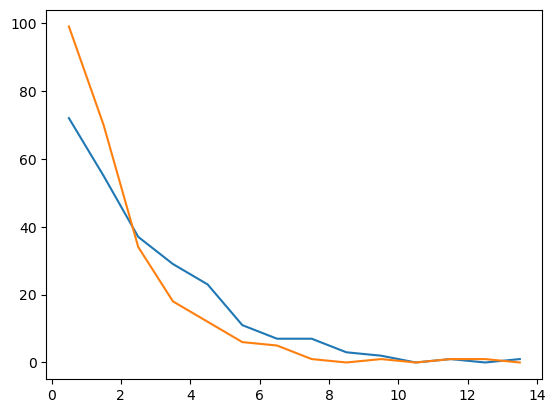

In [19]:
y0,x0 = np.histogram(tecrdb_dedup.loc[:,'nontrans_std'], range=(0.0, 14.0), bins=14)
y1,x1 = np.histogram(tecrdb_dedup.loc[:,'std'], range=(0.0, 14.0), bins=14)

plt.plot(x0[1:]-0.5, y0, )
plt.plot(x1[1:]-0.5, y1, )
plt.show()

Pre-processing formation dG

In [20]:
formation_dg = pd.read_csv('../data/formation_dg_smiles.csv')
formation_dg_copy = formation_dg.loc[pd.notna(formation_dg.loc[:,'standard_dg_prime']),['name', 'Smiles', 'temperature', 'ionic_strength', 'p_h', 'p_mg', 'standard_dg_prime']].copy()
formation_dg_copy = formation_dg_copy.rename(columns={'name':'description', 'Smiles':'reaction', 'temperature':'T', 'ionic_strength':'I', 'p_h':'pH', 'p_mg':'pMg'})

In [21]:
formation_dg_dedup = pd.DataFrame(index=range(len(set(formation_dg_copy.reaction))), 
                            columns=['description', 'reaction', 'T', 'I', 'pH', 'pMg', 
                                     'standard_dg_prime', 'std', 'n', 'SEM'])
i = 0
formation_dg_copy.index = formation_dg_copy.reaction
for r in set(formation_dg_copy.index):
    reaction = formation_dg_copy.loc[[r],:]
    formation_dg_dedup.loc[i,'description'] = reaction.loc[:,'description'][0]
    formation_dg_dedup.loc[i,'reaction'] = r
    formation_dg_dedup.loc[i,'standard_dg_prime'] = reaction.loc[:,'standard_dg_prime'].mean()
    formation_dg_dedup.loc[i,'std'] = reaction.loc[:,'standard_dg_prime'].std(ddof=1)
    formation_dg_dedup.loc[i,'n'] = reaction.shape[0]
    formation_dg_dedup.loc[i,'SEM'] = reaction.loc[:,'standard_dg_prime'].sem(ddof=1)
    i += 1
formation_dg_dedup.loc[:,['T','I','pH','pMg']] = [default_T, default_I, default_pH, default_pMg]

Label, merge, and save

In [22]:
formation_dg_dedup.loc[:,'type'] = 'formation dg'
tecrdb_dedup.loc[:,'type'] = 'reaction dg'
formation_dg_dedup = formation_dg_dedup.sort_values(by='description').reset_index(drop=True)
tecrdb_dedup = tecrdb_dedup.sort_values(by='description').reset_index(drop=True)

TrainingData_df = pd.concat([formation_dg_dedup, tecrdb_dedup], axis=0)
TrainingData_df.to_csv('../data/TrainingData.csv', index=False)

In [23]:
TrainingData_df = pd.read_csv('../data/TrainingData.csv')